In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from glob import glob
import math

# Import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread
import plotly.express as px

import keras

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

import os # used for navigating to image path
import imageio # used for writing images

import datetime

from PIL import Image
from PIL import ImageFile

##not sure why I need this but I do
ImageFile.LOAD_TRUNCATED_IMAGES = True


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


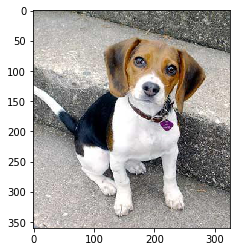

In [2]:
## Load the image
data = plt.imread('/Users/ilya/Desktop/U-Capstone/Images/n02088364-beagle/n02088364_2019.jpg')

# Display the image
plt.imshow(data)
plt.show()

In [3]:
# load the model
vgg16_model = VGG16()

def VGG16_predict(img_path):
    # load an image from file
    image = load_img(img_path, target_size=(224, 224))

    # convert the image pixels to a numpy array
    image = img_to_array(image)
    
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # prepare the image for the VGG model
    image = preprocess_input(image)

    # predict the probability across all output classes
    yhat = vgg16_model.predict(image)

    # convert the probabilities to class labels
    label = decode_predictions(yhat)
    
    return label

In [4]:
file_paths = []
image_ids = []
breed_labels = []

for directory in os.listdir('/Users/ilya/Desktop/U-Capstone/Images/'):
    if directory != '.DS_Store':
        for file in os.listdir('/Users/ilya/Desktop/U-Capstone/Images/'+str(directory)):
            file_paths.append('/Users/ilya/Desktop/U-Capstone/Images/'
                              +str(directory)+'/'+str(file))
            breed_labels.append(str(directory).split('-')[1])
            image_ids.append(file)

df = pd.DataFrame()

df['file_path'] = file_paths
df['image_id'] = image_ids
df['breed_label'] = breed_labels

In [19]:
#figuring out heights and widths of each image for better processing

list_of_heights = []
list_of_widths = []

for path in df['file_path']:
    image = load_img(path)
    np_array = img_to_array(image)
    list_of_heights.append(np_array.shape[0])
    list_of_widths.append(np_array.shape[1])

df.loc[:,('img_height')] = list_of_heights
df.loc[:,('img_width')] = list_of_widths

In [20]:
img_size = df[['img_height','img_width']]

img_size.describe()

,img_height,img_width
count,20580.000000,20580.000000
mean,385.861224,442.531876
std,124.863446,142.792308
min,100.000000,97.000000
25%,333.000000,361.000000
50%,375.000000,500.000000
75%,453.000000,500.000000
max,2562.000000,3264.000000


In [21]:
#binning a dataframe above by size for better visualization

img_size.loc[:,('img_height_bin')] = pd.cut(img_size['img_height'], list(range(0,4004, 100)))

img_size.loc[:,('img_width_bin')] = pd.cut(img_size['img_width'], list(range(0,4004, 100)))

img_size = img_size[img_size['img_height'] <= 2000]

img_size = img_size[img_size['img_width'] <= 2000]

heights = img_size.groupby('img_height_bin').count()[['img_height']].reset_index()
widths = img_size.groupby('img_width_bin').count()[['img_width']].reset_index()

heights.loc[:,('img_height_bin')] = heights['img_height_bin'].astype('str')
heigths2 = heights.rename(columns = {'img_height':'height_img_count'})

widths.loc[:,('img_width_bin')] = widths['img_width_bin'].astype('str')
widths2 = widths.rename(columns = {'img_width':'width_img_count'})

sizes_df = heigths2.merge(widths2, left_index = True, right_index = True).rename(columns = {'img_height_bin':'size'})\
           [['size','height_img_count','width_img_count']]

sizes_df.head(4)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,size,height_img_count,width_img_count
0,"(0, 100]",3,2
1,"(100, 200]",901,808
2,"(200, 300]",2233,1847
3,"(300, 400]",11395,4779


In [34]:
import plotly.graph_objects as go
sizes=sizes_mini_df['size']

fig = go.Figure(data=[
    go.Bar(name='heights', x=sizes, y=sizes_mini_df['height_img_count']),
    go.Bar(name='widths', x=sizes, y=sizes_mini_df['width_img_count'])
])

# Change the bar mode
fig.update_layout(barmode='group')
fig.update_layout(height = 500, width = 1000)
fig.show()

In [35]:
#we count the number of dog images per breed discovering the fact the the dataset in slightly imbalanced

breed_count_df = df.groupby('breed_label').count().reset_index()\
                .rename(columns = {'file_path':'dog_count'})[['breed_label','dog_count']]\
                .sort_values(by = 'dog_count', ascending = False)

fig = px.bar(breed_count_df, x='breed_label', y='dog_count')

fig.update_layout(title_text = 'Image Count by Breed',
                  yaxis_title = 'Number of Images',
                  xaxis_title = 'Dog Breed')

fig.show()

In [7]:
df2 = df.merge(breed_count_df, left_on= 'breed_label', right_on = 'breed_label')
final_df = df2[df2.dog_count > 200]
final_df = final_df.sample(frac = 1)
final_df = final_df[['file_path','image_id','breed_label']]

In [8]:
train_df = final_df.iloc[:round(len(final_df)*0.8)]
test_df = final_df.iloc[round(len(final_df)*0.8):]

In [9]:
def img_to_np_array(path):
    image = Image.open(path)
    image = image.resize((250,250))
    image = image.convert('L')
    image = np.array(image)
    return image

In [10]:
train_data = []

time1 = datetime.datetime.now()

for file_path, breed_label in zip(train_df['file_path'], train_df['breed_label']):
    img_np_array = img_to_np_array(file_path)
    train_data.append([img_np_array, breed_label])

np.random.shuffle(train_data)    

train_images = np.array([i[0] for i in train_data])
train_labels = np.array([i[1] for i in train_data])

train_images = train_images.reshape(-1, 250, 250, 1)

train_labels_df = pd.get_dummies(train_labels)
train_labels = pd.get_dummies(train_labels).to_numpy()
    
time2 = datetime.datetime.now()
elapsedTime = time2 - time1
run_time = elapsedTime.total_seconds()

print('Run time: {} seconds'.format(run_time))

Run time: 16.394181 seconds


In [11]:
test_data = []

time1 = datetime.datetime.now()

for file_path, breed_label in zip(test_df['file_path'], test_df['breed_label']):
    img_np_array = img_to_np_array(file_path)
    test_data.append([img_np_array, breed_label])

np.random.shuffle(test_data)    

test_images = np.array([i[0] for i in test_data])
test_labels = np.array([i[1] for i in test_data])

test_images = test_images.reshape(-1, 250, 250, 1)
test_labels = pd.get_dummies(test_labels).to_numpy()
    
time2 = datetime.datetime.now()
elapsedTime = time2 - time1
run_time = elapsedTime.total_seconds()

print('Run time: {} seconds'.format(run_time))

Run time: 4.955958 seconds


In [12]:
print("Shape of train image dataset: {}".format(train_images.shape))
print("Shape of test image dataset: {}".format(test_images.shape))
print("Shape of train label dataset: {}".format(train_labels.shape))
print("Shape of test label dataset: {}".format(test_labels.shape))

Shape of train image dataset: (2603, 250, 250, 1)
Shape of test image dataset: (651, 250, 250, 1)
Shape of train label dataset: (2603, 15)
Shape of test label dataset: (651, 15)


In [13]:
# Import the necessary components from Keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D

# Initialize the model object
model = Sequential()

# Add a convolutional layer
model.add(Conv2D(filters = 16, kernel_size=3, strides = 1,
                 padding = 'same', activation='relu',
                 input_shape=(250, 250, 1)))

model.add(MaxPooling2D(pool_size = 2))

# Add a convolutional layer
model.add(Conv2D(filters = 32, kernel_size=3, strides = 1,
                 padding = 'same', activation='relu'))

model.add(MaxPooling2D(pool_size = 2))

# Add a convolutional layer
model.add(Conv2D(filters = 64, kernel_size=3, strides = 1,
                 padding = 'same', activation='relu'))

model.add(MaxPooling2D(pool_size = 2))

model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(15, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0

In [14]:
training = model.fit(train_images, train_labels, batch_size = 50, epochs = 10, validation_split=0.3)
training

Epoch 1/10
37/37 [==============================] - 76s 2s/step - loss: 8.8555 - accuracy: 0.0675 - val_loss: 2.7533 - val_accuracy: 0.0679
Epoch 2/10
37/37 [==============================] - 74s 2s/step - loss: 2.7302 - accuracy: 0.0653 - val_loss: 2.7154 - val_accuracy: 0.0653
Epoch 3/10
37/37 [==============================] - 95s 3s/step - loss: 2.6981 - accuracy: 0.0611 - val_loss: 2.7131 - val_accuracy: 0.0717
Epoch 4/10
37/37 [==============================] - 90s 2s/step - loss: 2.6818 - accuracy: 0.0776 - val_loss: 2.7009 - val_accuracy: 0.0691
Epoch 5/10
37/37 [==============================] - 79s 2s/step - loss: 2.6752 - accuracy: 0.0919 - val_loss: 2.6929 - val_accuracy: 0.0871
Epoch 6/10
37/37 [==============================] - 76s 2s/step - loss: 2.6555 - accuracy: 0.1062 - val_loss: 2.6771 - val_accuracy: 0.1152
Epoch 7/10
37/37 [==============================] - 83s 2s/step - loss: 2.6509 - accuracy: 0.1337 - val_loss: 2.6877 - val_accuracy: 0.0960
Epoch 8/10
37/37 [==

In [36]:
training_history_df = pd.DataFrame(training.history)
training_history_df = training_history_df.reset_index().rename(columns = {'index':'epoch'})
training_history_df

,epoch,loss,accuracy,val_loss,val_accuracy
0,0,4.995424,0.077387,2.753291,0.067862
1,1,2.720537,0.066959,2.715422,0.065301
2,2,2.694504,0.066959,2.713092,0.071703
3,3,2.688181,0.079583,2.700900,0.069142
4,4,2.676099,0.103732,2.692931,0.087068
5,5,2.667253,0.103732,2.677077,0.115237
6,6,2.644195,0.132272,2.687737,0.096031
7,7,2.636809,0.120746,2.660256,0.112676
8,8,2.617791,0.135016,2.649351,0.126761
9,9,2.608219,0.137212,2.625842,0.135723


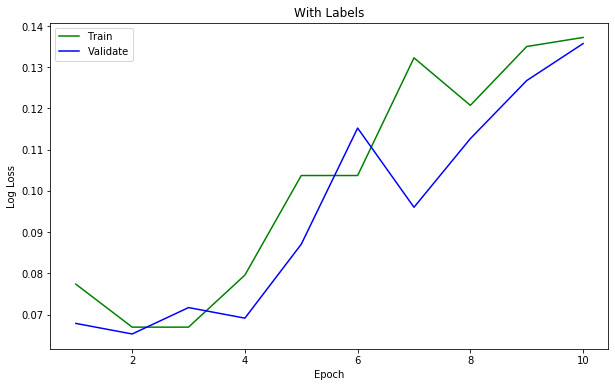

In [18]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()

plt.plot(list(range(1,11)), training.history['accuracy'], color='green', label="Train")
plt.plot(list(range(1,11)), training.history['val_accuracy'], color='blue', label="Validate")

plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("With Labels")

plt.legend(loc='best')
plt.show()

In [37]:
model.evaluate(test_images, test_labels)

21/21 [==============================] - 7s 305ms/step - loss: 2.6073 - accuracy: 0.1306


[2.607325792312622, 0.13056835532188416]

In [45]:
samoyed = img_to_np_array('/Users/ilya/Desktop/U-Capstone/samoyed-puppy-in-grass.jpeg').reshape(1,250,250,1)

In [46]:
prediction = model.predict(samoyed)

In [57]:
%pprint

Pretty printing has been turned OFF


In [47]:
label_list = list(train_labels_df.columns)
label_list

['Afghan_hound',
 'Airedale',
 'Bernese_mountain_dog',
 'EntleBucher',
 'Great_Pyrenees',
 'Irish_wolfhound',
 'Leonberg',
 'Maltese_dog',
 'Pomeranian',
 'Samoyed',
 'Scottish_deerhound',
 'Sealyham_terrier',
 'Shih',
 'Tibetan_terrier',
 'basenji']

In [48]:
prediction_list = list(prediction[0])
prediction_list

[0.061776843,
 0.06985099,
 0.05059278,
 0.056825694,
 0.05707421,
 0.05678923,
 0.06951023,
 0.08338115,
 0.094307125,
 0.055790253,
 0.070337705,
 0.07566053,
 0.06818018,
 0.06824093,
 0.06168212]

In [49]:
predict_dict = {}

for a, b in zip(label_list, prediction_list):
    predict_dict[a] = b

In [50]:
predict_dict

{'Afghan_hound': 0.061776843,
 'Airedale': 0.06985099,
 'Bernese_mountain_dog': 0.05059278,
 'EntleBucher': 0.056825694,
 'Great_Pyrenees': 0.05707421,
 'Irish_wolfhound': 0.05678923,
 'Leonberg': 0.06951023,
 'Maltese_dog': 0.08338115,
 'Pomeranian': 0.094307125,
 'Samoyed': 0.055790253,
 'Scottish_deerhound': 0.070337705,
 'Sealyham_terrier': 0.07566053,
 'Shih': 0.06818018,
 'Tibetan_terrier': 0.06824093,
 'basenji': 0.06168212}